# Cat and Dog Predictor

This model built is trained on the dataset provided by [Kaggle](https://www.kaggle.com/c/dogs-vs-cats/data) in collaboration with Asirra.

Asirra (Animal Species Image Recognition for Restricting Access) is a HIP that works by asking users to identify photographs of cats and dogs. This task is difficult for computers, but studies have shown that people can accomplish it quickly and accurately. Many even think it's fun! Here is an example of the Asirra interface:

Asirra is unique because of its partnership with Petfinder.com, the world's largest site devoted to finding homes for homeless pets. They've provided Microsoft Research with over three million images of cats and dogs, manually classified by people at thousands of animal shelters across the United States. Kaggle is fortunate to offer a subset of this data for fun and research. 


## Getting our data ready 

The data for this project is already downloaded and stored in directories for accessing it in the project.

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py 

In [ ]:
# Importing dependancies
import os
import random
import pandas as pd
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from helper_functions import unzip_data, walk_through_dir, make_confusion_matrix

The data given is present in zip files so we need to un-zip the files before getting them ready for our project.

In [ ]:
unzip_data("/content/train.zip")
unzip_data("/content/test1.zip")

In [ ]:
walk_through_dir("/content/train")

There are 0 directories and 25000 images in '/content/train'.


In [ ]:
walk_through_dir("/content/test1")

There are 0 directories and 12500 images in '/content/test1'.


The data is not arranged well in files but we know each correct label for the image begins with the correct class and ends with a '.'(dot).

In [ ]:
# Read input files to create training dataset
filenames = os.listdir("/content/train")
categories = []

for filename in filenames:    
    category = filename.split('.')[0]

    if(category == 'dog'):        
        categories.append('dog')       
    else:        
        categories.append('cat')

df = pd.DataFrame({'filename' : filenames,    
                   'category' : categories})

In [ ]:
df.head()

,filename,category
0,cat.1946.jpg,cat
1,dog.888.jpg,dog
2,cat.3806.jpg,cat
3,dog.8801.jpg,dog
4,dog.11458.jpg,dog


In [ ]:
df["category"].value_counts()

cat    12500
dog    12500
Name: category, dtype: int64

## Splitting data into train and validation

In [ ]:
train_data_df, test_data_df = train_test_split(df,
                                               test_size=0.2,
                                               random_state=42)

So we will train our model on 20,000 images and validate it on the rest of 5,000 images.

In [ ]:
len(train_data_df), len(test_data_df)

(20000, 5000)

To randomly visualiize any image from our dataset.

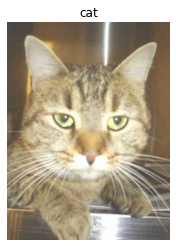

In [ ]:
random = random.choice(filenames)
img = plt.imread("/content/train/" + random)
plt.imshow(img)
plt.title(random.split('.')[0])
plt.axis(False);

In [ ]:
train_data_df["category"].value_counts()

dog    10041
cat     9959
Name: category, dtype: int64

In [ ]:
test_data_df["category"].value_counts()

cat    2541
dog    2459
Name: category, dtype: int64

## Generating data and preprocessing it before feeding in the model

In [ ]:
train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()

In [ ]:
train_data = train_datagen.flow_from_dataframe(train_data_df,
                                               "/content/train", 
                                               x_col='filename',
                                               y_col='category',
                                               target_size = (224, 224),
                                               batch_size = 32,
                                               class_mode = 'categorical')

test_data = test_datagen.flow_from_dataframe(test_data_df,
                                             "/content/train", 
                                              x_col='filename',
                                              y_col='category',
                                              target_size = (224, 224),
                                              batch_size = 32,
                                              class_mode = 'categorical',
                                              shuffle=False)

Found 20000 validated image filenames belonging to 2 classes.
Found 5000 validated image filenames belonging to 2 classes.


So we have 625 batches of training data and 157 batches of test_data

In [ ]:
len(train_data), len(test_data)

(625, 157)

## Model Building

For this model we will be using the `Efficientnetb0` model which already pretrained on the vast data of Imagenet and would be the best choice for this case.

One thing to keep in mind in case of `Efficientnetb0` is, it doesn't requires any normalization before passing the data into the model it already contains the layer for the same pre-built.

In [ ]:
# 1. Create a base model
base_model = tf.keras.applications.EfficientNetB0(include_top=False)

# 2. Freezing the layers of the base model
base_model.trainable = False

# 3. Creating an input layer
inputs = tf.keras.Input(shape=(224, 224, 3), name="input_layer")

# 4. Passing the inputs to the base model
x = base_model(inputs)

# 5. Average Pooling layer
x = tf.keras.layers.GlobalAveragePooling2D(name="global_average_pooling_layer")(x)

# 6. Output layer
outputs = tf.keras.layers.Dense(2, activation="softmax", name="output_layer")(x)

# 7. Combining inputs and output
model_1 = tf.keras.Model(inputs, outputs)

# 8. Compiling the model
model_1.compile(loss="categorical_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

# 9. Fit the model
history_1 = model_1.fit(train_data,
                        epochs=4,
                        steps_per_epoch=len(train_data),
                        validation_data=test_data,
                        validation_steps=int(0.25 * len(test_data))) 

Epoch 1/4
625/625 [==============================] - 78s 118ms/step - loss: 0.0559 - accuracy: 0.9817 - val_loss: 0.0398 - val_accuracy: 0.9840
Epoch 2/4
625/625 [==============================] - 72s 116ms/step - loss: 0.0290 - accuracy: 0.9905 - val_loss: 0.0345 - val_accuracy: 0.9848
Epoch 3/4
625/625 [==============================] - 72s 116ms/step - loss: 0.0251 - accuracy: 0.9912 - val_loss: 0.0343 - val_accuracy: 0.9888
Epoch 4/4
625/625 [==============================] - 72s 116ms/step - loss: 0.0236 - accuracy: 0.9923 - val_loss: 0.0344 - val_accuracy: 0.9872


## Evaluation

In [ ]:
model_1.evaluate(test_data)

157/157 [==============================] - 17s 108ms/step - loss: 0.0325 - accuracy: 0.9888


[0.03248189017176628, 0.9887999892234802]

## Viewing the predictions and insights of the model

In [ ]:
test_data_df.head()

,filename,category
6868,dog.4104.jpg,dog
24016,dog.5376.jpg,dog
9668,cat.7540.jpg,cat
13640,cat.1113.jpg,cat
14018,cat.11731.jpg,cat


In [ ]:
preds = model_1.predict(test_data)

In [ ]:
preds[:32]

array([[1.8283102e-03, 9.9817169e-01],
       [4.1874658e-04, 9.9958128e-01],
       [9.9999666e-01, 3.3090537e-06],
       [9.9999344e-01, 6.5714103e-06],
       [9.9999475e-01, 5.2636769e-06],
       [1.5100565e-04, 9.9984896e-01],
       [9.8240489e-01, 1.7595157e-02],
       [5.1839403e-03, 9.9481601e-01],
       [9.9999046e-01, 9.4982079e-06],
       [6.7498739e-04, 9.9932504e-01],
       [2.2526896e-04, 9.9977475e-01],
       [9.9994397e-01, 5.5968972e-05],
       [9.9998462e-01, 1.5355836e-05],
       [9.9997771e-01, 2.2345224e-05],
       [9.9999809e-01, 1.9498939e-06],
       [9.9998629e-01, 1.3679110e-05],
       [9.9997282e-01, 2.7119971e-05],
       [9.0793887e-04, 9.9909210e-01],
       [4.3716035e-03, 9.9562836e-01],
       [9.4669364e-02, 9.0533060e-01],
       [9.9995923e-01, 4.0820123e-05],
       [1.5311606e-03, 9.9846882e-01],
       [8.4613876e-06, 9.9999154e-01],
       [4.3985050e-04, 9.9956018e-01],
       [1.6684357e-05, 9.9998331e-01],
       [8.1442719e-05, 9.

In [ ]:
preds[0]

array([0.00182831, 0.9981717 ], dtype=float32)

In [ ]:
preds = preds.argmax(axis=0)

In [ ]:
preds.shape

(5000, 2)

In [ ]:
preds = preds.argmax(axis=1)
preds[:5]

array([1, 1, 0, 0, 0])

In [ ]:
true = []

for category in test_data_df["category"]:
  if category == "cat":
    true.append(0)
  else :
    true.append(1)

In [ ]:
true[:5]

[1, 1, 0, 0, 0]

In [ ]:
len(preds) == len(true)

True

In [ ]:
len(preds), len(true)

(5000, 5000)

In [ ]:
sklearn_accuracy = accuracy_score(true, preds)
sklearn_accuracy

0.9888

## Confusion Matrix

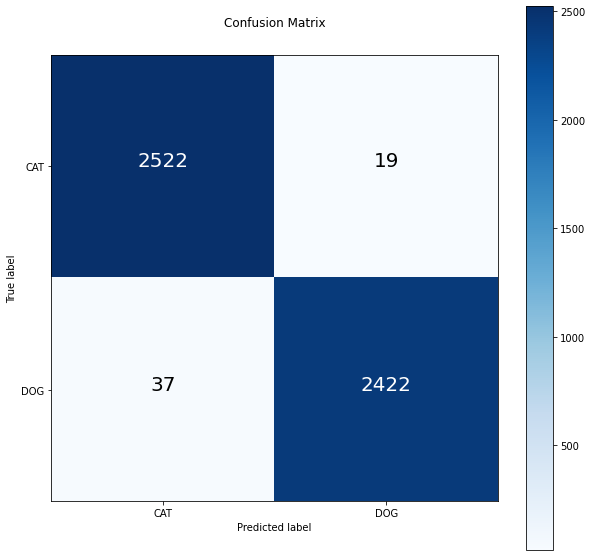

In [ ]:
# Plot a confusion matrix with all 25250 predictions, ground truth labels and 101 classes
make_confusion_matrix(y_true=true,
                      y_pred=preds,
                      classes=["CAT", "DOG"],
                      # figsize=(100, 100),
                      text_size=20,
                      norm=False,
                      savefig=True)

In [ ]:
print(classification_report(true, preds))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      2541
           1       0.99      0.98      0.99      2459

    accuracy                           0.99      5000
   macro avg       0.99      0.99      0.99      5000
weighted avg       0.99      0.99      0.99      5000



In [ ]:
model_1.save("/content/drive/MyDrive/DOGvsCAT_Model")

/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


INFO:tensorflow:Assets written to: /content/drive/MyDrive/DOGvsCAT_Model/assets


In [ ]:
model = tf.keras.models.load_model("/content/drive/MyDrive/DOGvsCAT_Model")

In [ ]:
model.summary()

Model: "model_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_layer (InputLayer)     [(None, 224, 224, 3)]     0         
_________________________________________________________________
efficientnetb0 (Functional)  (None, None, None, 1280)  4049571   
_________________________________________________________________
global_average_pooling_layer (None, 1280)              0         
_________________________________________________________________
output_layer (Dense)         (None, 2)                 2562      
Total params: 4,052,133
Trainable params: 2,562
Non-trainable params: 4,049,571
_________________________________________________________________


## Getting insights on the most wrong predictions made by the model

In [ ]:
filenames = os.listdir("/content/train")
files = []

for filename in test_data_df["filename"]:
  str = "/content/train/" + filename
  files.append(str)

files[:10]

['/content/train/dog.4104.jpg',
 '/content/train/dog.5376.jpg',
 '/content/train/cat.7540.jpg',
 '/content/train/cat.1113.jpg',
 '/content/train/cat.11731.jpg',
 '/content/train/dog.2420.jpg',
 '/content/train/cat.4666.jpg',
 '/content/train/dog.8995.jpg',
 '/content/train/cat.6679.jpg',
 '/content/train/dog.8048.jpg']

In [ ]:
pred_conf = model.predict(test_data)
pred_conf[:5]

array([[1.8283102e-03, 9.9817169e-01],
       [4.1874658e-04, 9.9958128e-01],
       [9.9999666e-01, 3.3090537e-06],
       [9.9999344e-01, 6.5714103e-06],
       [9.9999475e-01, 5.2636769e-06]], dtype=float32)

In [ ]:
y_pred_classname = []

for elem in preds:
  if elem == 0:
    y_pred_classname.append("cat")
  else :
    y_pred_classname.append("dog")

In [ ]:
pred_df = pd.DataFrame({"img_path": files,
                        "y_true": true,
                        "y_pred": preds,
                        "pred_conf": pred_conf.max(axis=1), # get the maximum prediction probability value
                        "y_true_classname": test_data_df["category"],
                        "y_pred_classname": y_pred_classname}) 
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname
6868,/content/train/dog.4104.jpg,1,1,0.998172,dog,dog
24016,/content/train/dog.5376.jpg,1,1,0.999581,dog,dog
9668,/content/train/cat.7540.jpg,0,0,0.999997,cat,cat
13640,/content/train/cat.1113.jpg,0,0,0.999993,cat,cat
14018,/content/train/cat.11731.jpg,0,0,0.999995,cat,cat


In [ ]:
# Checking the prediction
pred_df["pred_correct"] = pred_df["y_true"] == pred_df["y_pred"]
pred_df.head()

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
6868,/content/train/dog.4104.jpg,1,1,0.998172,dog,dog,True
24016,/content/train/dog.5376.jpg,1,1,0.999581,dog,dog,True
9668,/content/train/cat.7540.jpg,0,0,0.999997,cat,cat,True
13640,/content/train/cat.1113.jpg,0,0,0.999993,cat,cat,True
14018,/content/train/cat.11731.jpg,0,0,0.999995,cat,cat,True


In [ ]:
# Get the top wrong examples
top_20_wrong = pred_df[pred_df["pred_correct"] == False].sort_values("pred_conf", ascending=False)
top_20_wrong.head(7)

,img_path,y_true,y_pred,pred_conf,y_true_classname,y_pred_classname,pred_correct
17139,/content/train/cat.4085.jpg,0,1,0.999789,cat,dog,False
24752,/content/train/cat.7599.jpg,0,1,0.996646,cat,dog,False
4110,/content/train/dog.11526.jpg,1,0,0.996497,dog,cat,False
513,/content/train/cat.1361.jpg,0,1,0.990570,cat,dog,False
14438,/content/train/dog.1745.jpg,1,0,0.987529,dog,cat,False
547,/content/train/dog.3773.jpg,1,0,0.986411,dog,cat,False
17736,/content/train/cat.3105.jpg,0,1,0.983638,cat,dog,False


In [ ]:
def load_and_prep_image(filename, img_shape=224, scale=True):
  
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode it into a tensor
  img = tf.io.decode_image(img)
  # Resize the image
  img = tf.image.resize(img, [img_shape, img_shape])
  if scale:
    # Rescale the image (get all values between 0 and 1)
    return img/255.
  else:
    return img

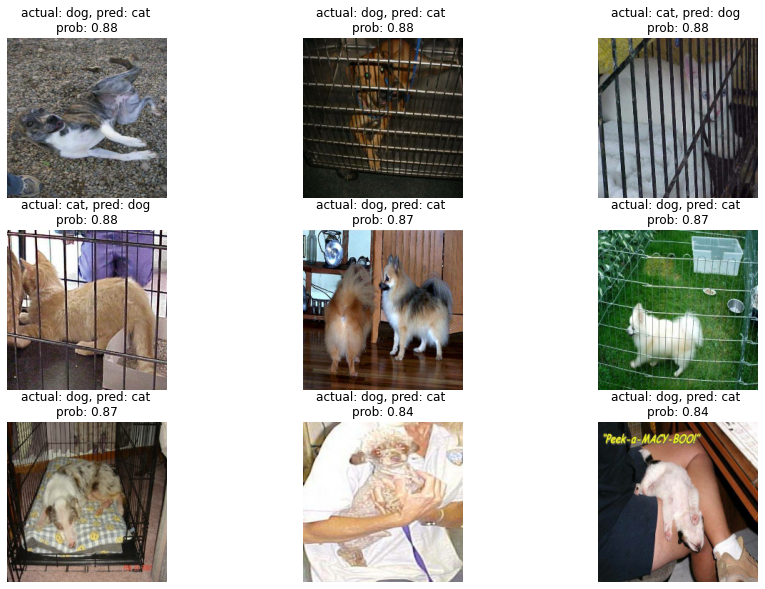

In [ ]:
# 5. Visualize some of the most wrong examples
images_to_view = 9
start_index = 20 # change the start index to view more
plt.figure(figsize=(15, 10))
for i, row in enumerate(top_20_wrong[start_index:start_index+images_to_view].itertuples()): 
  plt.subplot(3, 3, i+1)
  img = load_and_prep_image(row[1], scale=True)
  _, _, _, _, pred_prob, y_true, y_pred, _ = row # only interested in a few parameters of each row
  plt.imshow(img)
  plt.title(f"actual: {y_true}, pred: {y_pred} \nprob: {pred_prob:.2f}")
  plt.axis(False)


## Predictions on custom images

In [ ]:
# function to import image and resize 
def load_and_prep_image(filename, img_shape=224):
  """
  Reads an image from filename, turns it into a tensor and reshapes it to (img_shape, img_shape,, color_channels)
  """
  # Read in the image
  img = tf.io.read_file(filename)
  # Decode the read file into a tensor
  img = tf.image.decode_image(img)
  # Resize the image  
  img = tf.image.resize(img, size=IMAGE_SHAPE)
  #Grayscale
  print(f"Image before conv = {img.shape}")
  if img.shape[2] == 1:
    img = tf.image.grayscale_to_rgb(img)
    print(f"Image after conv = {img.shape}")
  # Rescale the image (getting all values between 0 & 1)
  # img = img/255

  return img

In [ ]:
def pred_and_plot(model, filename, class_names=["cat", "dog"]):
  """
  Imports an image located at filename, makes a prediction with model and plots the image with the predicted class as the title.
  """
  # Import target image and preprocess it 
  img = load_and_prep_image(filename)

  # Make a prediction 
  pred = model.predict(tf.expand_dims(img, axis=0))
  # pred = model.predict(tf.squeeze(img))
  print(f"Prediction is {tf.squeeze(pred).numpy()}")
  # print(f"Prediction is {pred}")

  # Get the predicted class 
  # pred_class = class_names[int(tf.round(pred))]
  pred_class = class_names[int(tf.argmax(tf.squeeze(pred).numpy()))]

  # Plot image and predicted class
  img = img/255
  plt.imshow(img)
  plt.title(f"Prediction : {pred_class}")
  plt.axis(False);

Image before conv = (224, 224, 3)
Prediction is [9.9994469e-01 5.5309887e-05]


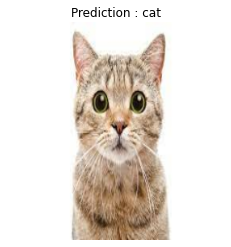

In [ ]:
IMAGE_SHAPE = (224, 224)
pred_and_plot(model, "/content/cat.jpg", class_names=["cat", "dog"])